In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (6,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_mod = self.exp_policy(state)
        action_user = np.argmax(state[:4])
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        next_state = next_dir_one_hot[:]
        next_state = np.array(next_state)
        
        self.replay_buffer.append(state, action_mod-1, reward_mod, next_state, done)
        
        
        return new_loc, reward_user, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.  0.4]
 [0.  0.9]
 [0.  0.4]
 [0.2 0.7]
 [0.2 0.6]
 [0.1 0.9]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

  0%|                                                                             | 17/100000 [00:00<10:07, 164.67it/s]

Mean Reward = -4.0
0


  0%|                                                                             | 108/100000 [00:01<26:05, 63.79it/s]

Updated Weights
Mean Reward = -4.58
20


  0%|▏                                                                            | 213/100000 [00:02<27:13, 61.09it/s]

Updated Weights
Mean Reward = -4.73
24


  0%|▏                                                                            | 306/100000 [00:04<30:39, 54.21it/s]

Updated Weights
Mean Reward = -5.54
19


  0%|▎                                                                            | 409/100000 [00:06<28:57, 57.32it/s]

Updated Weights
Mean Reward = -4.91
19


  0%|▍                                                                            | 498/100000 [00:07<28:25, 58.34it/s]

Updated Weights
Mean Reward = -4.9
21


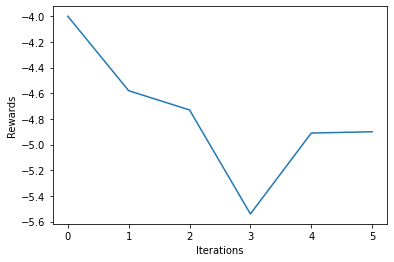

  1%|▍                                                                            | 611/100000 [00:10<31:08, 53.20it/s]

Updated Weights
Mean Reward = -3.86
27


  1%|▌                                                                            | 709/100000 [00:11<28:38, 57.78it/s]

Updated Weights
Mean Reward = -4.44
20


  1%|▌                                                                            | 806/100000 [00:14<41:35, 39.74it/s]

Updated Weights
Mean Reward = -3.89
28


  1%|▋                                                                            | 884/100000 [00:15<29:49, 55.38it/s]


KeyboardInterrupt: 

In [5]:
user_agent.model.load_weights('user_agent.h5')
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
#         user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
#         user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%250==0:
        mod_agent.epsilon*=0.9
#         user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    if epoch%100==0:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [ ]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    state = np.array(state)
    print(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1

In [ ]:
print(done)